# Evaluation and vizualisation

## Imports

In [12]:
from tracNet import TracNet
from data_preparation import matFiles_to_npArray, reshape
from training_and_evaluation import test, predictTrac
from data_visualization import plotCell

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from IPython.display import Image
from shapely.geometry import Point, Polygon
from scipy.io import loadmat, savemat
from scipy.interpolate import interp2d

Set seeds for reproducability.

In [13]:
random_seed = 2
np.random.seed(random_seed)
torch.manual_seed(random_seed)

The test sets are of small size, so no CUDA support is needed.

In [14]:
device = torch.device('cpu')

Load all relevant models.

In [31]:
model_SGD = TracNet(n_channels=1).double().to(device)
model_SGD.load_state_dict(torch.load('/Users/alex/LRZ Sync+Share/ML in Physics/Models/TracNet104-2022-Jun-22 18:43:08_best val_rmse_is_2.601_SGD.pth'), strict=False)

<All keys matched successfully>

In [32]:
model_ADAM = TracNet(n_channels=1).double().to(device)
model_ADAM.load_state_dict(torch.load('/Users/alex/LRZ Sync+Share/ML in Physics/Models/TracNet104-2022-Jun-17 13:07:58_best val_rmse_is_1.537.pth'), strict=False)

<All keys matched successfully>

## Evaluation

### 1. Artificial test data from authors

Prepare test data.

In [35]:
# Test data
test_dspl_path = '/Users/alex/LRZ Sync+Share/ML in Physics/Repos/DL-TFM-main/test/generic/testData104/dspl'
test_trac_path = '/Users/alex/LRZ Sync+Share/ML in Physics/Repos/DL-TFM-main/test/generic/testData104/trac'

In [36]:
X_test = matFiles_to_npArray(test_dspl_path) # each dict has keys ['brdx', 'brdy', 'dspl', 'name']
y_test = matFiles_to_npArray(test_trac_path) # each dict has keys ['brdx', 'brdy', 'trac', 'name']

Calculate loss for both models.

In [60]:
_, errors_SGD = test(X_test, y_test, model_SGD, 10670, plot=False)
_, errors_ADAM = test(X_test, y_test, model_ADAM, 10670, plot=False)

Compare the losses.

In [37]:
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [37]:
df = pd.read_csv("/home/alexrichard/PycharmProjects/ml_in_biophysics/outputs/TError.csv", usecols= ["File ID", "104"])
df = df.assign(error_Matlab_SGD=[tensor.item() for tensor in dict(sorted(errors_SGD.items())).values()])
df = df.assign(error_Matlab_ADAM=[tensor.item() for tensor in dict(sorted(errors_ADAM.items())).values()])
df = df.rename(columns = {"104":"TracNet_SGD_Matlab error", "error_Matlab_SGD":"TracNet_SGD_Python error", "error_Matlab_ADAM":"TracNet_ADAM_Python error"}).round(decimals=4)
df = df.append({'File ID':'', 'TracNet_SGD_Matlab error': f"avg: {round(df['TracNet_SGD_Matlab error'].mean(), ndigits=4)}", 'TracNet_SGD_Python error': f"avg: {round(df['TracNet_SGD_Python error'].mean(), ndigits=4)}", 'TracNet_ADAM_Python error': f"avg: {round(df['TracNet_ADAM_Python error'].mean(), ndigits=4)}"}, ignore_index=True)
df.style.set_properties(**{'text-align': 'center', 'font-size': '11pt'})

,File ID,TracNet_SGD_Matlab error,TracNet_SGD_Python error,TracNet_ADAM_Python error
0,#0018,0.114,0.187,0.113
1,#0022,0.123,0.265,0.155
2,#0023,0.102,0.192,0.107
3,#0024,0.115,0.254,0.110
4,#0025,0.114,0.205,0.105
5,#0027,0.117,0.254,0.119
6,#0030,0.101,0.194,0.110
7,#0034,0.128,0.200,0.118
8,#0037,0.102,0.185,0.101
9,#0038,0.110,0.220,0.122


Visualize the displacement field of one test-cell both as strain vector field and strain heat map.

<IPython.core.display.Javascript object>


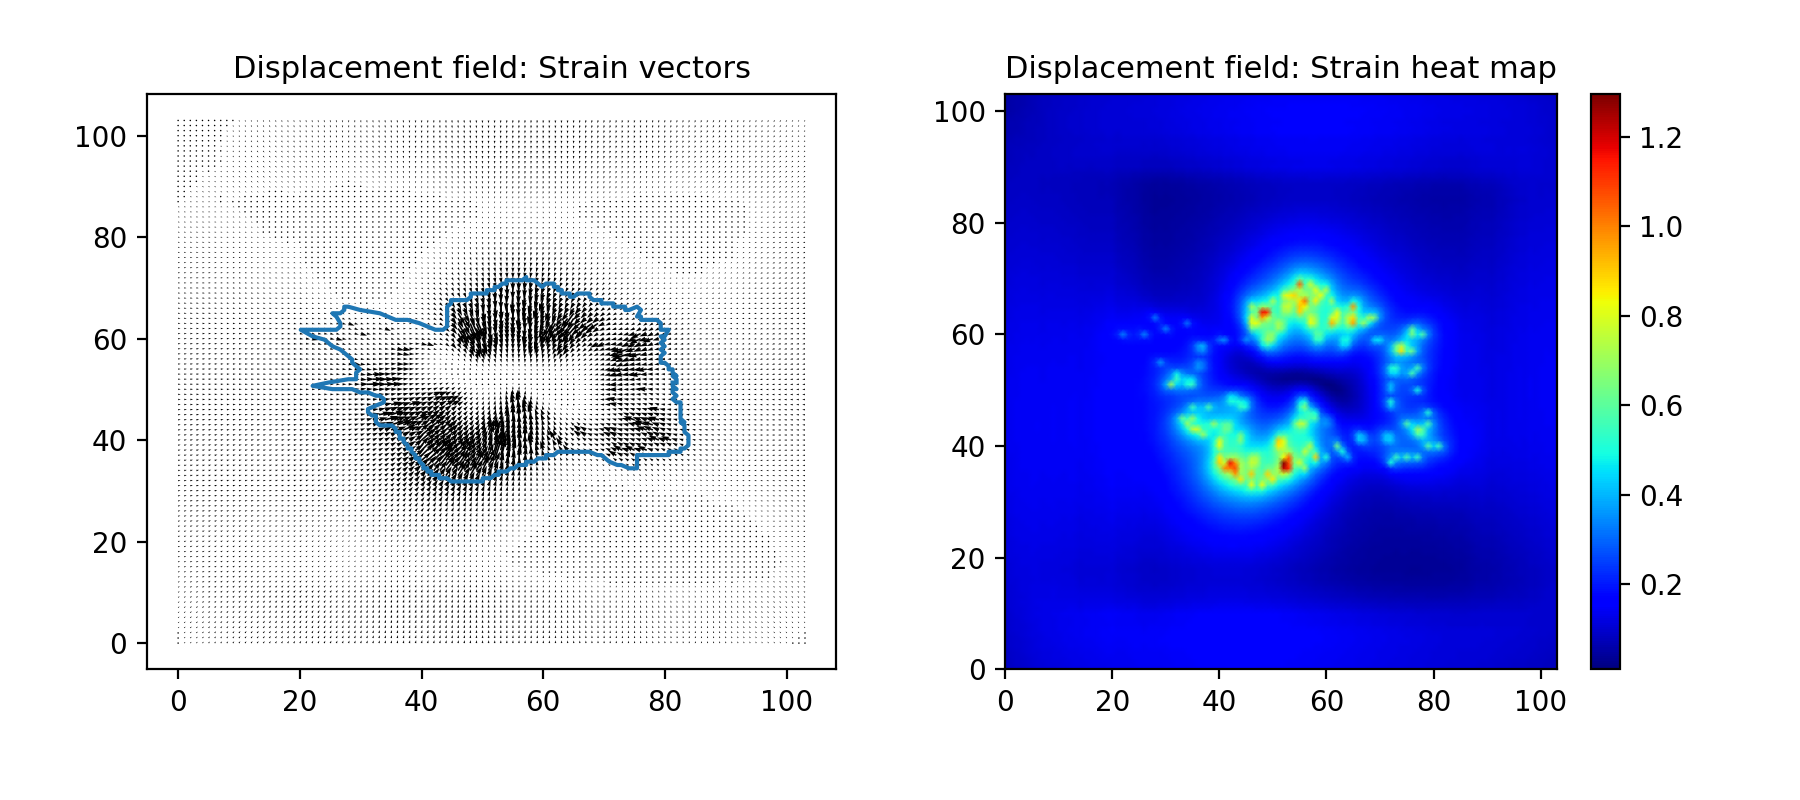

Text(0.5, 1.0, 'Displacement field: Strain heat map')

In [38]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1,2, figsize=(9, 4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0].quiver(X_test[5]['dspl'][:,:,0].T, X_test[5]['dspl'][:,:,1].T, scale=35)
axs[0].set_title('Displacement field: Strain vectors', {'fontsize': 11})
axs[0].plot(X_test[5]['brdx'][0], X_test[5]['brdy'][0])

C = np.sqrt(X_test[5]['dspl'][:,:,0].T ** 2 + X_test[5]['dspl'][:,:,1].T ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1])
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Displacement field: Strain heat map', {'fontsize': 11})

In [39]:
# @@ Cell 325
predictions = {}
predictions['TracNet_SGD_Matlab'] = loadmat('/home/alexrichard/PycharmProjects/ml_in_biophysics/outputs/Tracnet_SGD_Matlab.mat')
predictions['TracNet_SGD_Python'] = np.moveaxis(predictTrac(torch.from_numpy(reshape(X_test[5]['dspl'][np.newaxis, :])), model_SGD, E=10670).detach().numpy()[0][0], [0,2], [2,0])
predictions['TracNet_ADAM_Python'] = np.moveaxis(predictTrac(torch.from_numpy(reshape(X_test[5]['dspl'][np.newaxis, :])), model_ADAM, E=10670).detach().numpy()[0][0], [0,2], [2,0])

FileNotFoundError: [Errno 2] No such file or directory: '/home/alexrichard/PycharmProjects/ml_in_biophysics/outputs/Tracnet_SGD_Matlab.mat'

<IPython.core.display.Javascript object>


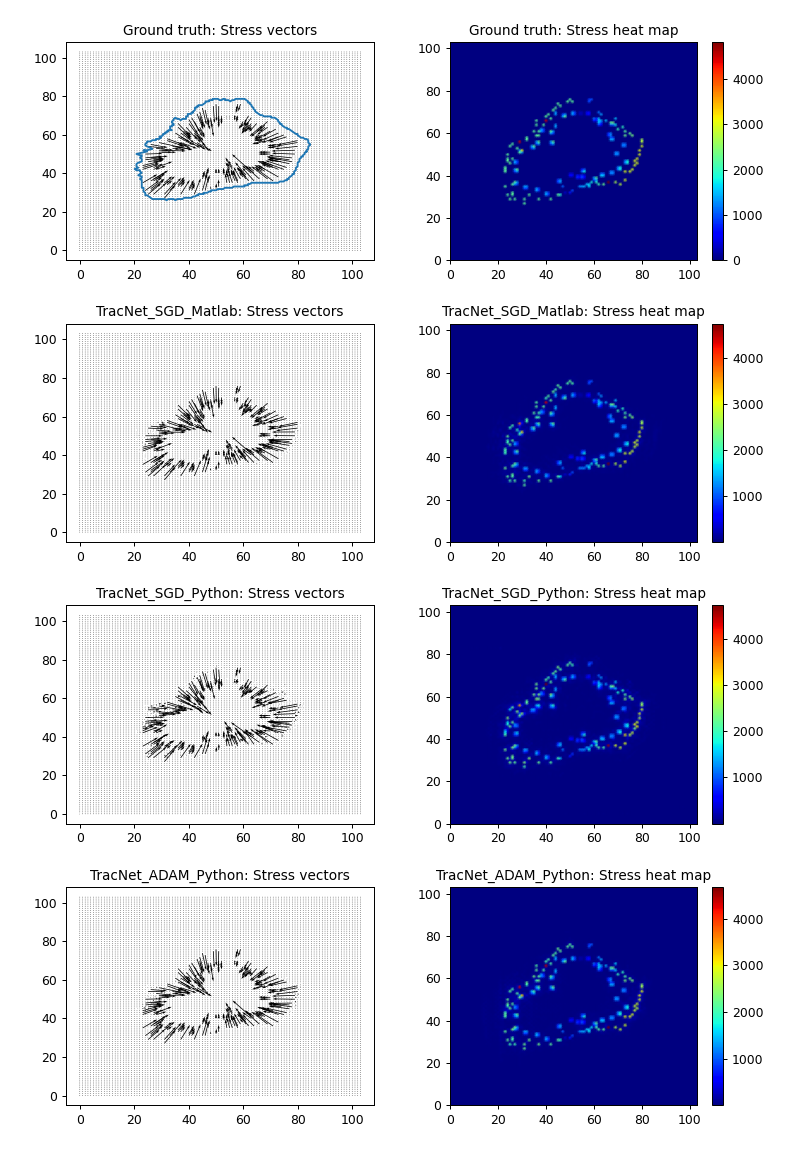

In [66]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(4, 2, figsize=(9, 13))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(y_test[5]['trac'][:,:,0].T, y_test[5]['trac'][:,:,1].T, scale=40000)
axs[0, 0].set_title('Ground truth: Stress vectors', {'fontsize': 11})
axs[0, 0].plot(y_test[5]['brdx'][0], y_test[5]['brdy'][0])

C = np.sqrt(y_test[5]['trac'][:,:,0].T ** 2 + y_test[5]['trac'][:,:,1].T ** 2)
im = axs[0,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[0,1])
axs[0,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0,1].set_title('Ground truth: Stress heat map', {'fontsize': 11})

axs[1, 0].quiver(predictions['TracNet_SGD_Matlab']['matlab_pred'][:,:,0].T, predictions['TracNet_SGD_Matlab']['matlab_pred'][:,:,1].T, scale=40000)
axs[1, 0].set_title('TracNet_SGD_Matlab: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['TracNet_SGD_Matlab']['matlab_pred'][:,:,0].T ** 2 + predictions['TracNet_SGD_Matlab']['matlab_pred'][:,:,1].T ** 2)
im = axs[1,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1,1])
axs[1,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1,1].set_title('TracNet_SGD_Matlab: Stress heat map', {'fontsize': 11})

axs[2, 0].quiver(predictions['TracNet_SGD_Python'][:,:,0].T, predictions['TracNet_SGD_Python'][:,:,1].T, scale=40000)
axs[2, 0].set_title('TracNet_SGD_Python: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['TracNet_SGD_Python'][:,:,0].T ** 2 + predictions['TracNet_SGD_Python'][:,:,1].T ** 2)
im = axs[2,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[2,1])
axs[2,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[2,1].set_title('TracNet_SGD_Python: Stress heat map', {'fontsize': 11})

axs[3, 0].quiver(predictions['TracNet_ADAM_Python'][:,:,0].T, predictions['TracNet_ADAM_Python'][:,:,1].T, scale=40000)
axs[3, 0].set_title('TracNet_ADAM_Python: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['TracNet_ADAM_Python'][:,:,0].T ** 2 + predictions['TracNet_ADAM_Python'][:,:,1].T ** 2)
im = axs[3,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[3,1])
axs[3,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[3,1].set_title('TracNet_ADAM_Python: Stress heat map', {'fontsize': 11})


plt.show()

### 2. Experimental data from authors

Load data.

In [41]:
experimental_dspl_path = 'Users/alex/LRZ Sync+Share/ML in Physics/Repos/DL-TFM-main/cells/cells/dspl'
experimental = matFiles_to_npArray(experimental_dspl_path) # each dict has keys ['brdx', 'brdy', 'dspl', 'name']

FileNotFoundError: [Errno 2] No such file or directory: 'Users/alex/LRZ Sync+Share/ML in Physics/Repos/DL-TFM-main/cells/cells/dspl'

Plot strain field for one cell.

<IPython.core.display.Javascript object>


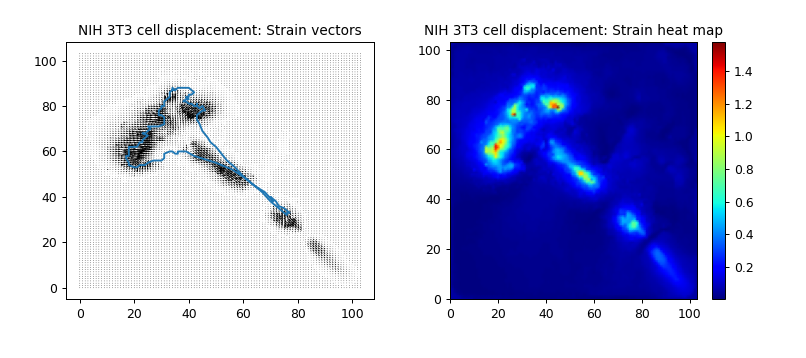

Text(0.5, 1.0, 'NIH 3T3 cell displacement: Strain heat map')

In [68]:
fig, axs = plt.subplots(1,2, figsize=(9, 4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0].quiver(experimental[0]['dspl'][:,:,0].T, experimental[0]['dspl'][:,:,1].T, scale=35)
axs[0].set_title('NIH 3T3 cell displacement: Strain vectors', {'fontsize': 11})
axs[0].plot(experimental[0]['brdx'][0], experimental[0]['brdy'][0])

C = np.sqrt(experimental[0]['dspl'][:,:,0].T ** 2 +experimental[0]['dspl'][:,:,1].T ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1])
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('NIH 3T3 cell displacement: Strain heat map', {'fontsize': 11})

Calculate and plot predictions for this example.

In [71]:
# @@ Cell 301
predictions = {}
predictions['TracNet_SGD_Matlab'] = loadmat('/home/alexrichard/PycharmProjects/ml_in_biophysics/outputs/Exp_pred.mat')
predictions['TracNet_SGD_Python'] = np.moveaxis(predictTrac(torch.from_numpy(reshape(experimental[0]['dspl'][np.newaxis, :])), model_SGD, E=10670).detach().numpy()[0][0], [0,2], [2,0])
predictions['TracNet_ADAM_Python'] = np.moveaxis(predictTrac(torch.from_numpy(reshape(experimental[0]['dspl'][np.newaxis, :])), model_ADAM, E=10670).detach().numpy()[0][0], [0,2], [2,0])
# predictions['Easy-to-use_TFM'] = loadmat('/home/alexrichard/PycharmProjects/ml_in_biophysics/outputs/easy_trac_pred.mat')

<IPython.core.display.Javascript object>


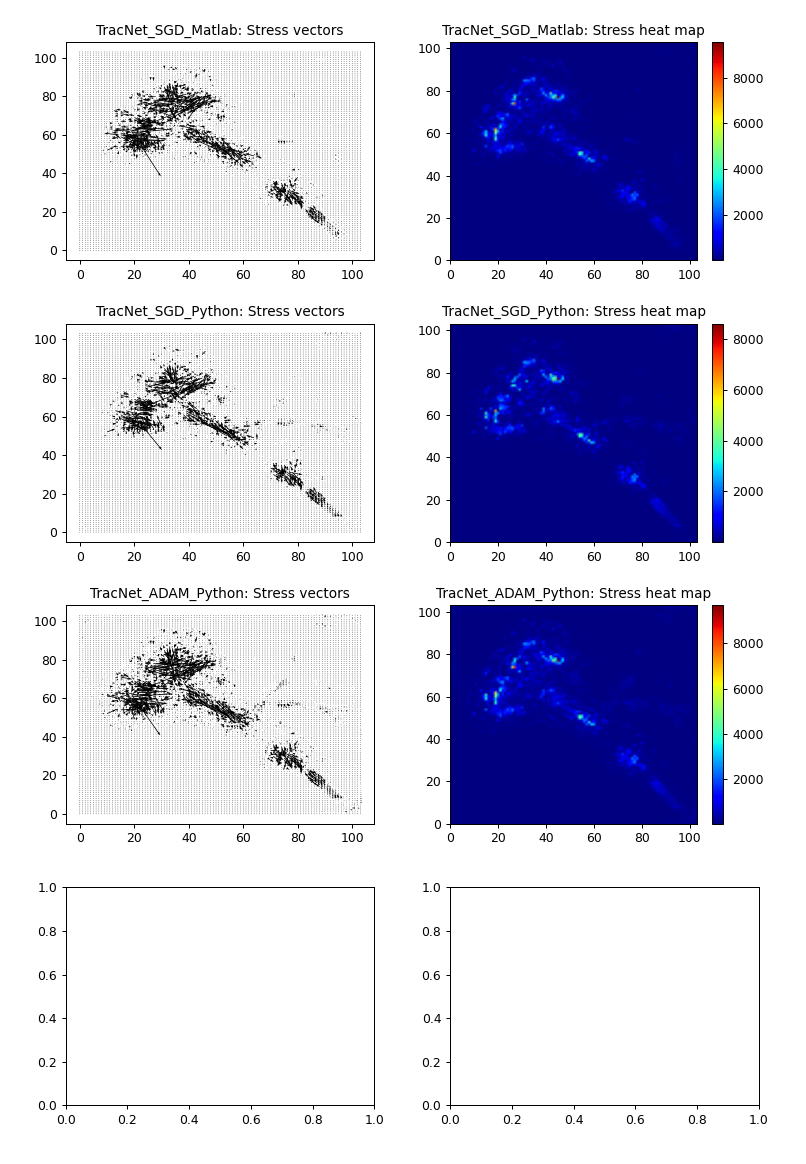

In [74]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(4, 2, figsize=(9, 13))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(predictions['TracNet_SGD_Matlab']['exp_trac'][:,:,0].T, predictions['TracNet_SGD_Matlab']['exp_trac'][:,:,1].T, scale=40000)
axs[0, 0].set_title('TracNet_SGD_Matlab: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['TracNet_SGD_Matlab']['exp_trac'][:,:,0].T ** 2 + predictions['TracNet_SGD_Matlab']['exp_trac'][:,:,1].T ** 2)
im = axs[0,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[0,1])
axs[0,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0,1].set_title('TracNet_SGD_Matlab: Stress heat map', {'fontsize': 11})

axs[1, 0].quiver(predictions['TracNet_SGD_Python'][:,:,0].T, predictions['TracNet_SGD_Python'][:,:,1].T, scale=40000)
axs[1, 0].set_title('TracNet_SGD_Python: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['TracNet_SGD_Python'][:,:,0].T ** 2 + predictions['TracNet_SGD_Python'][:,:,1].T ** 2)
im = axs[1,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1,1])
axs[1,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1,1].set_title('TracNet_SGD_Python: Stress heat map', {'fontsize': 11})

axs[2, 0].quiver(predictions['TracNet_ADAM_Python'][:,:,0].T, predictions['TracNet_ADAM_Python'][:,:,1].T, scale=40000)
axs[2, 0].set_title('TracNet_ADAM_Python: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['TracNet_ADAM_Python'][:,:,0].T ** 2 + predictions['TracNet_ADAM_Python'][:,:,1].T ** 2)
im = axs[2,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[2,1])
axs[2,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[2,1].set_title('TracNet_ADAM_Python: Stress heat map', {'fontsize': 11})

'''
axs[0, 0].quiver(y_test[5]['trac'][:,:,0].T, y_test[5]['trac'][:,:,1].T, scale=40000)
axs[0, 0].set_title('Ground truth: Stress vectors', {'fontsize': 11})
axs[0, 0].plot(y_test[5]['brdx'][0], y_test[5]['brdy'][0])

C = np.sqrt(y_test[5]['trac'][:,:,0].T ** 2 + y_test[5]['trac'][:,:,1].T ** 2)
im = axs[0,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[0,1])
axs[0,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0,1].set_title('Ground truth: Stress heat map', {'fontsize': 11})

'''

plt.show()

### 3. Artificial from Sabaß

Load data.

In [83]:
demo_dspl = loadmat('/home/alexrichard/PycharmProjects/ml_in_biophysics/outputs/demo_dspl.mat')['dspl']

In [84]:
savemat("dspl26.mat", dspl)
dspl['dspl_104'] = loadmat('/home/alexrichard/PycharmProjects/ml_in_biophysics/outputs/dspl104.mat')['dspl104']

NameError: name 'dspl' is not defined

In [82]:
dspl['dspl_104']

NameError: name 'dspl' is not defined

In [81]:
# @@ Cell 46
get_ipython().run_line_magic('matplotlib', 'notebook')
import matplotlib
import matplotlib.pyplot as plt
plt.quiver(dspl['dspl_104'][:,:,0].T, dspl['dspl_104'][:,:,1].T, scale=25)

NameError: name 'dspl' is not defined

In [1]:
%matplotlib notebook

fig, axs = plt.subplots(1,2, figsize=(9, 4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0].quiver(demo_dspl[:,:,0].T, demo_dspl[:,:,1].T, scale=35)
axs[0].set_title('demo_dspl: Strain vectors', {'fontsize': 11})

C = np.sqrt(demo_dspl[:,:,0].T ** 2 + demo_dspl[:,:,1].T ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1])
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('demo_dspl: Strain heat map', {'fontsize': 11})

NameError: name 'plt' is not defined

In [78]:
# @@ Cell 332
distance_matrix = np.sqrt(demo_dspl[:,:,0] ** 2 + demo_dspl[:,:,1] ** 2)
i, j = np.unravel_index(distance_matrix.argmin(), distance_matrix.shape)
padded_demo_dspl = np.zeros(shape=(26,26,2))
padded_demo_dspl[:,:,0] = np.pad(demo_dspl[:,:,0], ((3, 2), (2, 3)), 'constant', constant_values=(demo_dspl[i][j][0], demo_dspl[i][j][0]))
padded_demo_dspl[:,:,1] = np.pad(demo_dspl[:,:,1], ((3, 2), (2, 3)), 'constant', constant_values=(demo_dspl[i][j][0], demo_dspl[i][j][0]))

ValueError: could not broadcast input array from shape (109,109) into shape (26,26)

In [79]:
# @@ Cell 333
demo_dspl_dict = {}
demo_dspl_dict['dspl'] = demo_dspl
savemat("demo_dspl.mat", demo_dspl_dict)

In [89]:
# @@ Cell 334
predictions = {}
predictions['TracNet_SGD_Matlab'] = loadmat('/home/alexrichard/PycharmProjects/ml_in_biophysics/outputs/Demo_pred.mat')
predictions['TracNet_SGD_Python'] = np.moveaxis(predictTrac(torch.from_numpy(reshape(demo_dspl[np.newaxis, :])), model_SGD, E=10670).detach().numpy()[0][0], [0,2], [2,0])
predictions['TracNet_ADAM_Python'] = np.moveaxis(predictTrac(torch.from_numpy(reshape(demo_dspl[np.newaxis, :])), model_ADAM, E=10670).detach().numpy()[0][0], [0,2], [2,0])

<IPython.core.display.Javascript object>


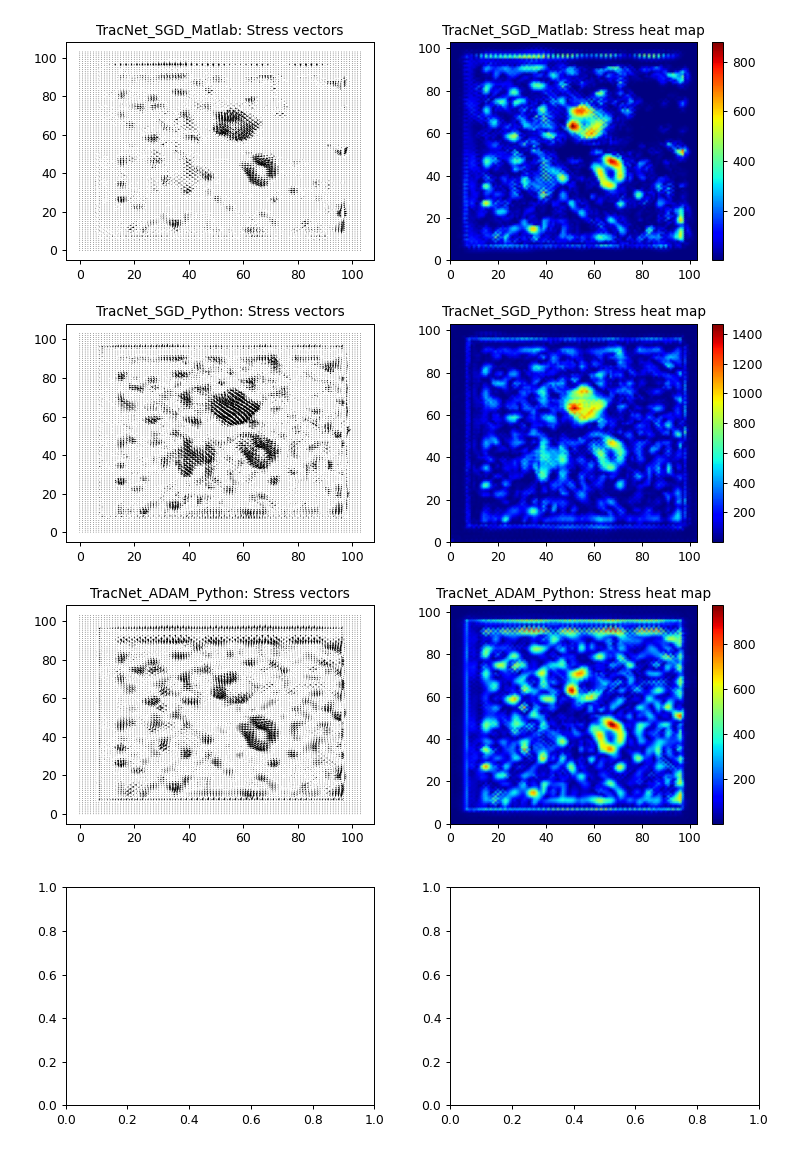

In [92]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(4, 2, figsize=(9, 13))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(predictions['TracNet_SGD_Matlab']['demo_trac'][:,:,0].T, predictions['TracNet_SGD_Matlab']['demo_trac'][:,:,1].T, scale=40000)
axs[0, 0].set_title('TracNet_SGD_Matlab: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['TracNet_SGD_Matlab']['demo_trac'][:,:,0].T ** 2 + predictions['TracNet_SGD_Matlab']['demo_trac'][:,:,1].T ** 2)
im = axs[0,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[0,1])
axs[0,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0,1].set_title('TracNet_SGD_Matlab: Stress heat map', {'fontsize': 11})

axs[1, 0].quiver(predictions['TracNet_SGD_Python'][:,:,0].T, predictions['TracNet_SGD_Python'][:,:,1].T, scale=40000)
axs[1, 0].set_title('TracNet_SGD_Python: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['TracNet_SGD_Python'][:,:,0].T ** 2 + predictions['TracNet_SGD_Python'][:,:,1].T ** 2)
im = axs[1,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1,1])
axs[1,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1,1].set_title('TracNet_SGD_Python: Stress heat map', {'fontsize': 11})

axs[2, 0].quiver(predictions['TracNet_ADAM_Python'][:,:,0].T, predictions['TracNet_ADAM_Python'][:,:,1].T, scale=40000)
axs[2, 0].set_title('TracNet_ADAM_Python: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['TracNet_ADAM_Python'][:,:,0].T ** 2 + predictions['TracNet_ADAM_Python'][:,:,1].T ** 2)
im = axs[2,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[2,1])
axs[2,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[2,1].set_title('TracNet_ADAM_Python: Stress heat map', {'fontsize': 11})

'''
axs[0, 0].quiver(y_test[5]['trac'][:,:,0].T, y_test[5]['trac'][:,:,1].T, scale=40000)
axs[0, 0].set_title('Ground truth: Stress vectors', {'fontsize': 11})
axs[0, 0].plot(y_test[5]['brdx'][0], y_test[5]['brdy'][0])

C = np.sqrt(y_test[5]['trac'][:,:,0].T ** 2 + y_test[5]['trac'][:,:,1].T ** 2)
im = axs[0,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[0,1])
axs[0,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0,1].set_title('Ground truth: Stress heat map', {'fontsize': 11})

'''

plt.show()

### 4 Experimental from Sabaß

In [46]:
# @@ Cell 301
predictions = {}
predictions['TracNet_SGD_Matlab'] = loadmat('/home/alexrichard/PycharmProjects/ml_in_biophysics/outputs/exp_trac.mat')
predictions['TracNet_SGD_Python'] = np.moveaxis(predictTrac(torch.from_numpy(reshape(experimental[0]['dspl'][np.newaxis, :])), model_SGD, E=10670).detach().numpy()[0][0], [0,2], [2,0])
predictions['TracNet_ADAM_Python'] = np.moveaxis(predictTrac(torch.from_numpy(reshape(experimental[0]['dspl'][np.newaxis, :])), model_ADAM, E=10670).detach().numpy()[0][0], [0,2], [2,0])
predictions['Easy-to-use_TFM'] = loadmat('/home/alexrichard/PycharmProjects/ml_in_biophysics/outputs/easy_trac_pred.mat')

FileNotFoundError: [Errno 2] No such file or directory: '/home/alexrichard/PycharmProjects/ml_in_biophysics/outputs/exp_trac.mat'